EXP NO: 01
DATE:

Understanding "Mobile Price" dataset by doing feature analysis

In [ ]:
# Mobile Price Classification - End-to-End Pipeline
# Step 1: Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
# Step 2: Load data
df = pd.read_csv("/content/train[1].csv")
print("Train shape:", df.shape)

# Optional test dataset
if os.path.exists("/content/test[1].csv"):
    df_test = pd.read_csv("/content/test[1].csv")
    print("Test shape:", df_test.shape)
else:
    df_test = None

df.head()

Train shape: (2000, 21)
Test shape: (1000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

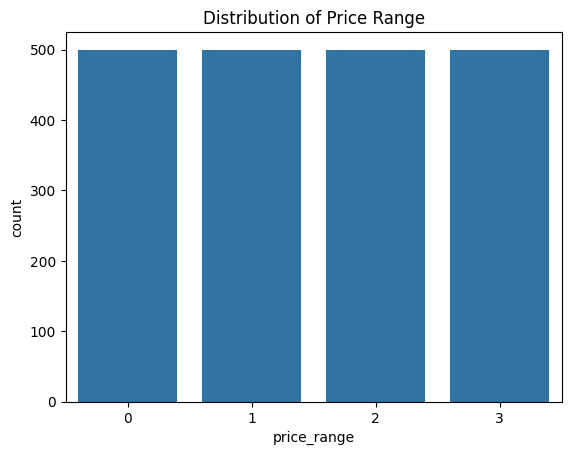

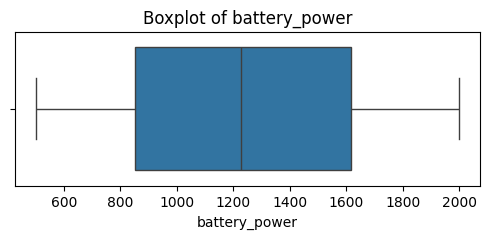

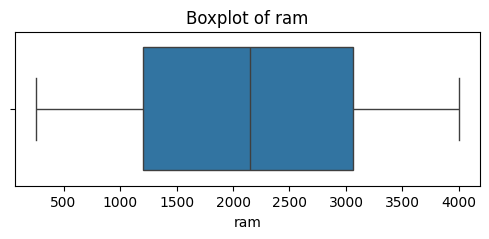

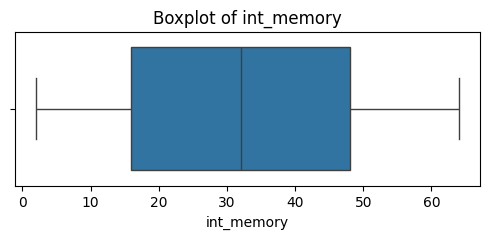

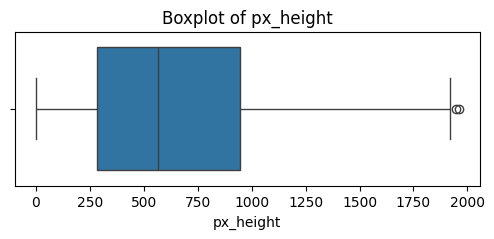

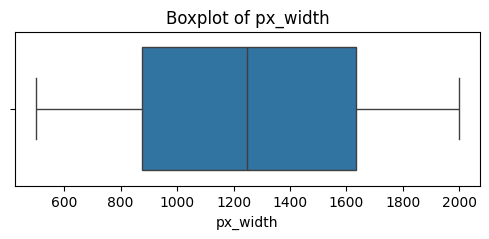

In [ ]:
# Step 3: Feature analysis / EDA
print(df.info())
print(df.describe().T)

# Distribution of target variable
sns.countplot(x="price_range", data=df)
plt.title("Distribution of Price Range")
plt.show()

# Boxplots for some features
for col in ["battery_power", "ram", "int_memory", "px_height", "px_width"]:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
# Step 4: Missing data analysis
print("Missing values per column:\n", df.isnull().sum())


Missing values per column:
 battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


In [ ]:
# Step 5: Outlier detection (IQR method)

binary_cols = ['blue','dual_sim','four_g','three_g','touch_screen','wifi']
target_col = 'price_range'
num_features = [c for c in df.select_dtypes(include=[np.number]).columns if c not in binary_cols+[target_col]]

def iqr_bounds(series, k=1.5):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

outlier_counts = {}
for col in num_features:
    l,u = iqr_bounds(df[col])
    outliers = ((df[col] < l) | (df[col] > u)).sum()
    outlier_counts[col] = outliers

pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["Outlier Count"])

,Outlier Count
battery_power,0
clock_speed,0
fc,18
int_memory,0
m_dep,0
mobile_wt,0
n_cores,0
pc,0
px_height,2
px_width,0


In [ ]:
# Step 6: Handle outliers (capping)
df_refined = df.copy()
for col in num_features:
    l,u = iqr_bounds(df_refined[col])
    df_refined[col] = np.where(df_refined[col] < l, l,
                        np.where(df_refined[col] > u, u, df_refined[col]))

df_refined.to_csv("refined_train.csv", index=False)
print("Refined train saved as refined_train.csv")

# Apply same bounds to test
if df_test is not None:
    df_test_refined = df_test.copy()
    for col in num_features:
        if col in df_test_refined.columns:
            l,u = iqr_bounds(df[col])
            df_test_refined[col] = np.where(df_test_refined[col] < l, l,
                                    np.where(df_test_refined[col] > u, u, df_test_refined[col]))
    df_test_refined.to_csv("refined_test.csv", index=False)
    print("Refined test saved as refined_test.csv")

Refined train saved as refined_train.csv
Refined test saved as refined_test.csv


In [ ]:
# Step 7: Prepare features and target
X = df_refined.drop(columns=[target_col])
y = df_refined[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.joblib")

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2,
                                                  stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)

Train shape: (1600, 20) Validation shape: (400, 20)


In [ ]:
# Step 8: Train models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = {"model": model, "val_accuracy": acc}
    print(f"{name}: Validation Accuracy = {acc:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression: Validation Accuracy = 0.9650
RandomForest: Validation Accuracy = 0.8750
GradientBoosting: Validation Accuracy = 0.9300
SVC: Validation Accuracy = 0.8950


In [ ]:
# Step 9: Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, entry in results.items():
    model = entry['model']
    cv_scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='accuracy', n_jobs=-1)
    results[name]['cv_mean'] = cv_scores.mean()
    results[name]['cv_std'] = cv_scores.std()
    print(f"{name}: CV Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

summary = pd.DataFrame([
    {"model": k, "val_acc": v['val_accuracy'], "cv_mean": v['cv_mean'], "cv_std": v['cv_std']}
    for k,v in results.items()
]).sort_values(by="cv_mean", ascending=False)

summary

LogisticRegression: CV Accuracy = 0.9610 ± 0.0030
RandomForest: CV Accuracy = 0.8890 ± 0.0163
GradientBoosting: CV Accuracy = 0.9120 ± 0.0134
SVC: CV Accuracy = 0.8755 ± 0.0205


,model,val_acc,cv_mean,cv_std
0,LogisticRegression,0.965,0.9610,0.003000
2,GradientBoosting,0.930,0.9120,0.013360
1,RandomForest,0.875,0.8890,0.016325
3,SVC,0.895,0.8755,0.020457


In [ ]:
# Step 10: Select best model

best_name = summary.iloc[0]['model']
best_model = results[best_name]['model']
print("Best Model:", best_name)

joblib.dump(best_model, f"best_model_{best_name}.joblib")

Best Model: LogisticRegression


['best_model_LogisticRegression.joblib']

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.96      0.96      0.96       100
           2       0.95      0.94      0.94       100
           3       0.96      0.98      0.97       100

    accuracy                           0.96       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.96      0.96       400

Confusion Matrix:
 [[98  2  0  0]
 [ 1 96  3  0]
 [ 0  2 94  4]
 [ 0  0  2 98]]


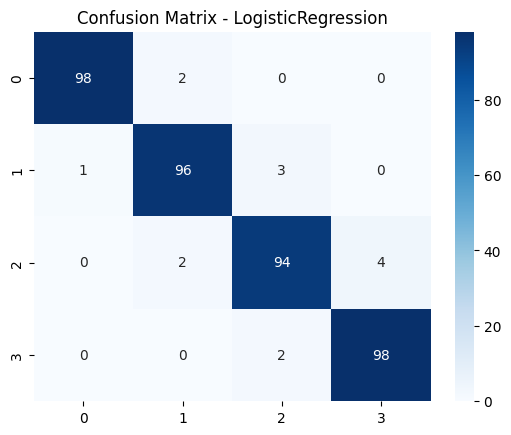

In [ ]:
# Step 11: Detailed performance of best model

y_pred_best = best_model.predict(X_val)

print("Classification Report:\n", classification_report(y_val, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_best))

sns.heatmap(confusion_matrix(y_val, y_pred_best), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

In [ ]:
# Step 12: Predict on Test Data (if available)
if df_test is not None:
    X_test = df_test_refined.drop(columns=[target_col, 'id']) if target_col in df_test_refined.columns else df_test_refined.drop(columns=['id'])
    X_test_scaled = scaler.transform(X_test)
    preds = best_model.predict(X_test_scaled)
    pd.DataFrame({"predicted_price_range": preds}).to_csv("test_predictions.csv", index=False)
    print("Saved test predictions to test_predictions.csv")

Saved test predictions to test_predictions.csv
